In [ ]:
%load_ext autoreload
%autoreload 2

%pip install langdetect
%pip install transformers
%pip install googletrans==3.1.0a0

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import pandas as pd
import yaml

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm.auto import tqdm

from langdetect import detect
from langdetect import LangDetectException
from googletrans import Translator
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import os
from pathlib import Path

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/modules')
import pipeline

print('Libraries Imported')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 20.6 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=175780ade69295306d00ba039b4b57a889b05a8ec22ca51ad00d864bd65839b2
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 18.6 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
     |████████████████████████████████| 101 kB 14.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.

In [ ]:
# Unzip files from drive to disk
main_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/AI4Code.zip'
kag_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/kag_train.zip'
jup_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/jup_train.zip'

main_disk_path = '/content/AI4Code'
kag_disk_path = '/content/kag_train'
jup_disk_path = '/content/jup_train'

pipeline.unzip_files(main_path, main_disk_path)
pipeline.unzip_files(kag_path, kag_disk_path)
pipeline.unzip_files(jup_path, jup_disk_path)

Unzipping files:   0%|          | 0/139263 [00:00<?, ?it/s]


 Done unzipping data to disk path.


Unzipping files:   0%|          | 0/166977 [00:00<?, ?it/s]


 Done unzipping data to disk path.


Unzipping files:   0%|          | 0/155030 [00:00<?, ?it/s]


 Done unzipping data to disk path.


In [ ]:
# Load all your dataframes in
def read_notebook(path):
    return (pd.read_json(path, dtype={'cell_type': 'category', 'source': 'str'})
              .assign(id=path.stem)
              .rename_axis('cell_id'))

main_path = Path('/content/AI4Code')
kag_paths = list(Path(kag_disk_path).glob('*.csv'))
jup_paths = list(Path(jup_disk_path).glob('*.csv'))
data_paths = list((main_path / 'train').glob('*.json'))

notebooks_train = [read_notebook(path) for path in tqdm(data_paths, desc='Train NBs')]

df = (pd.concat(notebooks_train)
        .set_index('id', append=True)
        .swaplevel()
        .sort_index(level='id', sort_remaining=False))

df_orders = pd.read_csv(main_path / 'train_orders.csv',
                        index_col='id',
                        squeeze=True).str.split()

df_ancestors = pd.read_csv(main_path / 'train_ancestors.csv', index_col='id')

Train NBs:   0%|          | 0/139256 [00:00<?, ?it/s]

In [ ]:
# Outlier collection
# def read_notebook(path):
#     return (pd.read_json(path, dtype={'cell_type': 'category', 'source': 'str'})
#               .assign(id=path.stem)
#               .rename_axis('cell_id'))

# main_path = Path('/content/AI4Code')
# kag_paths = list(Path(kag_disk_path).glob('*.csv'))
# jup_paths = list(Path(jup_disk_path).glob('*.csv'))
# data_paths = list((main_path / 'train').glob('*.json'))
# outlier_ids_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/outlier_ids.yaml'

# all_outliers = {}
# outlier_thresh = 125

# main_outliers = []
# kag_outliers = []
# jup_outliers = []

# for path in tqdm(data_paths, desc='Collecting Outliers'):
#   if len(read_notebook(path)) > outlier_thresh:
#     main_outliers.append(path.stem)

# for path in tqdm(kag_paths, desc='Collecting Outliers'):
#   if len(pd.read_csv(path)) > outlier_thresh:
#     kag_outliers.append(path.stem)

# for path in tqdm(jup_paths, desc='Collecting Outliers'):
#   if len(pd.read_csv(path)) > outlier_thresh:
#     jup_outliers.append(path.stem)

# all_outliers['ids'] = main_outliers + kag_outliers + jup_outliers
# print(len(all_outliers['ids']))
# print(all_outliers['ids'][:5])

# with open(outlier_ids_path, 'w+') as stream:
#   try:
#     yaml.dump(all_outliers, stream, default_flow_style=False)
#   except yaml.YAMLError as error:
#     print(error)

In [ ]:
# Create a filtered dataframe that excludes the excluded ids
excluded_ids_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/excluded_ids.yaml'

excluded_keys = ['outliers', 'similars']  # , 'single_code_cell', 'less_than_five', 'less_than_eight']  # Change depending on what you need or should exclude
excluded_ids = pipeline.load_excluded_ids(excluded_ids_path)

excluded_ids = {id
                for key, ids in excluded_ids.items()
                if key in excluded_keys
                for id in ids}
filtered_paths = pipeline.remove_excluded_id_paths(paths_train, excluded_ids)
filtered_notebooks = [read_notebook(path) for path in tqdm(filtered_paths, desc='Filtered NBs')]

filtered_df = (pd.concat(filtered_notebooks)
                .set_index('id', append=True)
                .swaplevel()
                .sort_index(level='id', sort_remaining=False))

Safe loaded in excluded IDs.


Filtered NBs:   0%|          | 0/120168 [00:00<?, ?it/s]

### Average Lengths

In [ ]:
code_cell_lengths = []
markdown_cell_lengths = []

for code_cell in filtered_df[filtered_df['cell_type']=='code'].loc[:, 'source']:
  code_cell_lengths.append(len(code_cell))

for markdown_cell in filtered_df[filtered_df['cell_type']=='markdown'].loc[:, 'source']:
  markdown_cell_lengths.append(len(markdown_cell))

code_cell_lengths = np.asarray(code_cell_lengths)
markdown_cell_lengths = np.asarray(markdown_cell_lengths)

In [ ]:
# Mean and medians including outliers lengths
# Does not consider preprocessing

print(f"The mean code cell length was {code_cell_lengths.mean():.2f} and the median was {np.median(code_cell_lengths)}")
print(f"The mean markdown cell length was {markdown_cell_lengths.mean():.2f} and the median was {np.median(markdown_cell_lengths)}")

print(f"\nThe longest code cell length was {np.max(code_cell_lengths)} and the shortest code cell length was {np.min(code_cell_lengths)}")
print(f"The longest markdown cell length was {np.max(markdown_cell_lengths)} and the shortest markdown cell length was {np.min(markdown_cell_lengths)}")

The mean code cell length was 314.13 and the median was 130.0
The mean markdown cell length was 247.86 and the median was 68.0

The longest code cell length was 802036 and the shortest code cell length was 1
The longest markdown cell length was 1003358 and the shortest markdown cell length was 1


In [ ]:
# Rejecting outlier lengths
def reject_upper_outliers(data, deviations=2):
    return data[(abs(data - np.mean(data))) < (deviations * np.std(data))]

norm_code_cell_lengths = reject_upper_outliers(code_cell_lengths)
norm_markdown_cell_lengths = reject_upper_outliers(markdown_cell_lengths)

print(f"The mean norm code cell length was {norm_code_cell_lengths.mean():.2f} and the median was {np.median(norm_code_cell_lengths)}")
print(f"The mean norm markdown cell length was {norm_markdown_cell_lengths.mean():.2f} and the median was {np.median(norm_markdown_cell_lengths)}")

print(f"\nThe longest norm code cell length was {np.max(norm_code_cell_lengths)} and the shortest code cell length was {np.min(norm_code_cell_lengths)}")
print(f"The longest norm markdown cell length was {np.max(norm_markdown_cell_lengths)} and the shortest markdown cell length was {np.min(norm_markdown_cell_lengths)}")

The mean norm code cell length was 268.90 and the median was 129.0
The mean norm markdown cell length was 190.88 and the median was 68.0

The longest norm code cell length was 3635 and the shortest code cell length was 1
The longest norm markdown cell length was 8457 and the shortest markdown cell length was 1


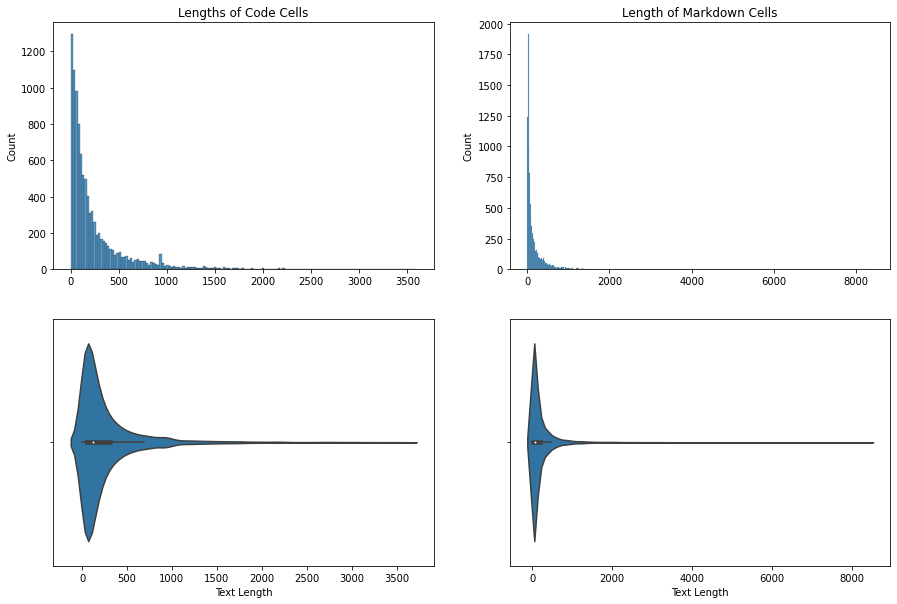

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0][0].set(title='Lengths of Code Cells')
ax[1][0].set(xlabel='Text Length')
ax[0][0] = sns.histplot(x=norm_code_cell_lengths[:10000], ax=ax[0][0])
ax[1][0] = sns.violinplot(x=norm_code_cell_lengths[:10000], ax=ax[1][0])

ax[0][1].set(title='Length of Markdown Cells')
ax[1][1].set(xlabel='Text Length')
ax[0][1] = sns.histplot(x=norm_markdown_cell_lengths[:10000], ax=ax[0][1])
ax[1][1] = sns.violinplot(x=norm_markdown_cell_lengths[:10000], ax=ax[1][1])

### Outliers

In [ ]:
# Outliers cause large cell counts so we will remove them
# I don't want very large code counts to be over representative within the train dataset

df_cell_counts = {}
for id, doc_cells in tqdm(df.groupby(level=0), desc='Getting Doc Cell Counts'):
  df_cell_counts[id] = len(doc_cells)

sorted_cell_counts = np.asarray(sorted(df_cell_counts.items(), key=lambda x:x[1], reverse=True))

Getting Doc Cell Counts:   0%|          | 0/139256 [00:00<?, ?it/s]

Mean cell count is 45.75 and median cell count is 35.0


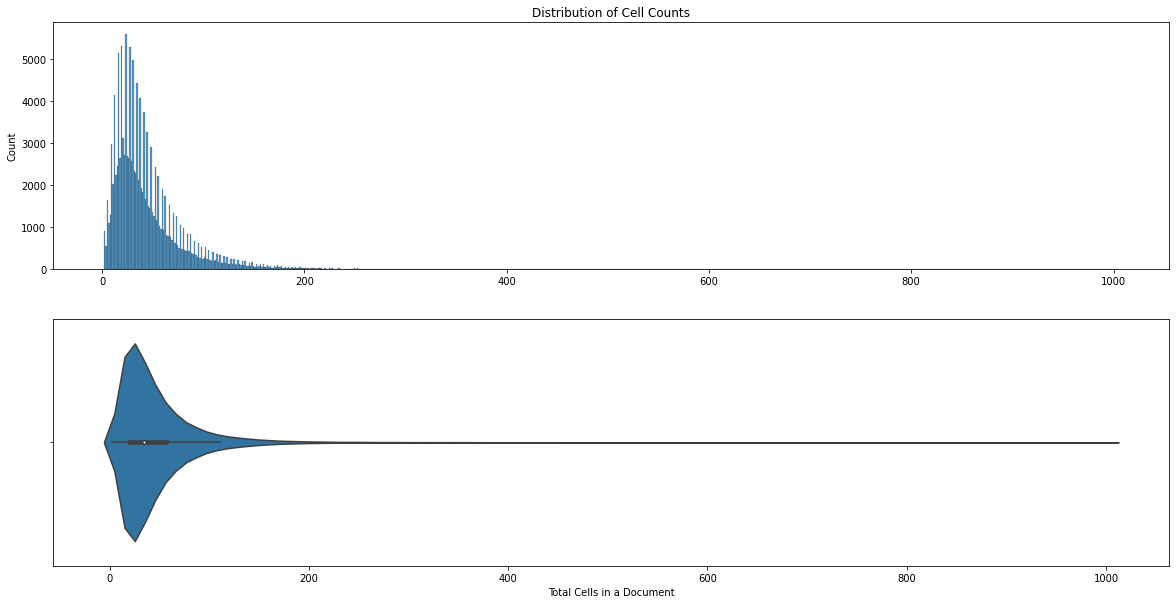

In [ ]:
all_cell_counts = sorted_cell_counts[:,1].astype('int32')

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0] = sns.histplot(x=all_cell_counts, ax=ax[0])
ax[1] = sns.violinplot(x=all_cell_counts, ax=ax[1])
ax[0].set(title='Distribution of Cell Counts')
ax[1].set(xlabel='Total Cells in a Document')
print(f"Mean cell count is {all_cell_counts.mean():.2f} and median cell count is {np.median(all_cell_counts)}")

In [ ]:
# Start filtering them, let's see how many documents we lose once we start cutting them
# Ok we will filter them out

outlier_multiplier = 2.2  # Standard is IQR*1.5 or 1.5 multiplier
outlier_thresh = np.percentile(all_cell_counts, [75])[0]*outlier_multiplier
outlier_count = len(np.where(all_cell_counts < outlier_thresh)[0])

print(f"There are {outlier_count} outliers. They are outliers if they have more than {outlier_thresh} cells.")

There are 133392 outliers. They are outliers if they have more than 125.4 cells.


In [ ]:
# Collect the document IDs that have too many cell counts
outliers = []

for doc_id, cell_count in tqdm(df_cell_counts.items(), desc='Collecting Outliers'):
  if cell_count > outlier_thresh:
    outliers.append(doc_id)

In [ ]:
# Add ids to the current excluded_ids yaml file

# excluded_ids_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/excluded_ids.yaml'

# with open(excluded_ids_path, 'r+') as stream:
#   try:
#     excluded_ids = yaml.safe_load(stream)
#     excluded_ids['outliers'] = outliers
#     yaml.dump(excluded_ids, stream, default_flow_style=False)
#   except yaml.YAMLError as error:
#     print(error)

### Code Cell Specifics

In [ ]:
outlier_code_cell_counts = []

for outlier_id in tqdm(outliers, desc='Counting Outlier Code Cell Counts'):
  outlier_code_cell_counts.append(df.loc[outlier_id, 'cell_type'].value_counts()['code'])

outlier_code_cell_counts = np.asarray(outlier_code_cell_counts, dtype=np.int32)

Counting Outlier Code Cell Counts:   0%|          | 0/10860 [00:00<?, ?it/s]

Mean of the outlier code cells counts is 94.08 and median is 84.00.


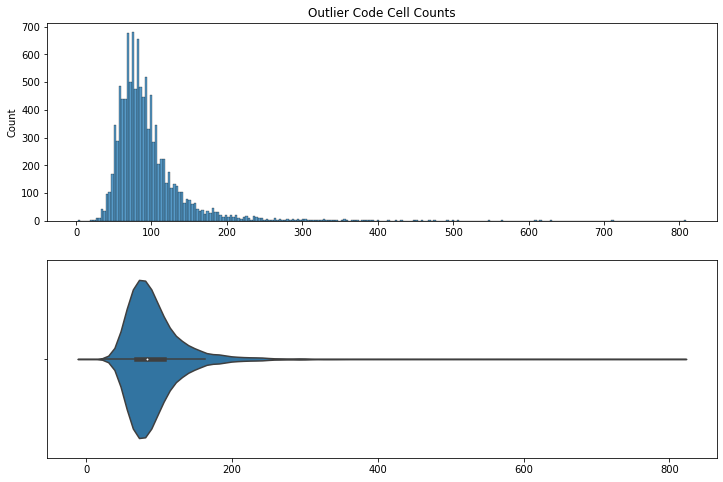

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0] = sns.histplot(x=outlier_code_cell_counts, ax=ax[0])
ax[1] = sns.violinplot(x=outlier_code_cell_counts, ax=ax[1])
_ = ax[0].set(title='Outlier Code Cell Counts')
print(f"Mean of the outlier code cells counts is {outlier_code_cell_counts.mean():.2f} and median is {np.median(outlier_code_cell_counts):.2f}.")

### Strange Files

In [ ]:
# Check for notebooks with no code cells and remove notebooks with no markdown cells in them

code_type_count = {}
markdown_type_count = {}
baseline_code_cell_counts = []

for id, doc_cells in tqdm(df.groupby(level=0), desc='Getting Doc Cell Counts'):
  cell_counts = doc_cells.loc[:, 'cell_type'].value_counts()
  if id not in outliers:
    baseline_code_cell_counts.append(cell_counts['code'])
  cell_counts = doc_cells.loc[:, 'cell_type'].value_counts()
  code_type_count[id] = cell_counts['code']
  markdown_type_count[id] = cell_counts['markdown']

baseline_code_cell_counts = np.asarray(baseline_code_cell_counts)
print(f"Mean code cell count without outliers is {baseline_code_cell_counts.mean()} and the median is {np.median(baseline_code_cell_counts)}")

Getting Doc Cell Counts:   0%|          | 0/139256 [00:00<?, ?it/s]

Mean code cell count without outliers is 24.789713075173683 and the median is 21.0


30.193183776641582
23.0
809


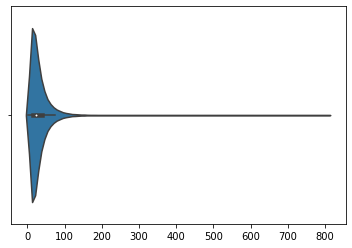

In [ ]:
true_code_counts = np.asarray(list(code_type_count.values()))
print(true_code_counts.mean())
print(np.median(true_code_counts))
print(np.max(true_code_counts))
_ = sns.violinplot(x=true_code_counts)

15.554547021313265
11.0
537


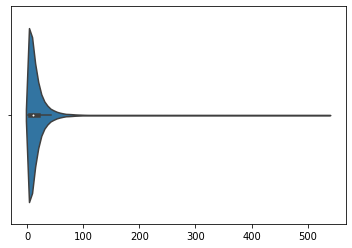

In [ ]:
# Gather the mean, median, and distribution here
true_md_counts = np.asarray(list(markdown_type_count.values()))
print(true_md_counts.mean())
print(np.median(true_md_counts))
print(np.max(true_md_counts))
_ = sns.violinplot(x=true_md_counts)
# lmao why didn't you print the numbers kekw?

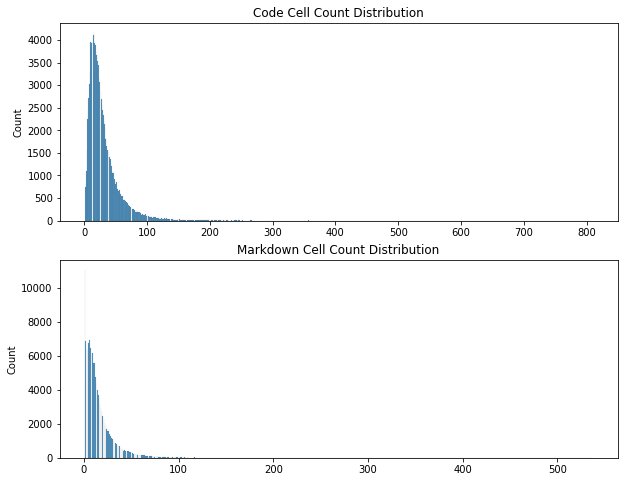

In [ ]:
# Plot the distributions

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0] = sns.histplot(x=list(code_type_count.values()), ax=ax[0])
ax[1] = sns.histplot(x=list(markdown_type_count.values()), ax=ax[1])
_ = ax[0].set(title='Code Cell Count Distribution')
_ = ax[1].set(title='Markdown Cell Count Distribution')

In [ ]:
# Double check if there are any documents with no code or markdown cells in the current database
# As confirmed in the rules of the competition

for id, markdown_count in markdown_type_count.items():
  if markdown_count == 0:
    print(f"{id} has no markdowns cells")

for id, code_count in code_type_count.items():
  if code_count == 0:
    print(f"{id} has no code cells")

In [ ]:
# Strange orientations would be only 1 code cell and 1 or more markdown cells

# If we run 6 code cells and want to wiggle around for top 3, you need at least 8 code cells right

# Less than 4, there needs to be at least 4 quadrants

single_code_ids = []
single_markdown_ids = []

for id, cell_count in code_type_count.items():
  if cell_count < 4:
    single_code_ids.append(id)

for id, cell_count in markdown_type_count.items():
  if cell_count == 1:
    single_markdown_ids.append(id)

print(f"There are {len(single_code_ids)} documents with only 1 code cell")
print(f"There are {len(single_markdown_ids)} documents with only 1 markdown cell")

There are 2644 documents with only 1 code cell
There are 11081 documents with only 1 markdown cell


In [ ]:
# # Dump to excluded ids

# with open(excluded_ids_path, 'r+') as stream:
#   try:
#     excluded_ids = yaml.safe_load(stream)
#     excluded_ids['less_than_four'] = single_code_ids
#     yaml.dump(excluded_ids, stream, default_flow_style=False)
#   except yaml.YAMLError as error:
#     print(error)

# print('Successfully dumped to the YAML file')

Successfully dumped to the YAML file


### Languages

In [ ]:
# Gather non-english IDs. This takes around 45 minutes

# non_english_ids = {}
# markdown_df = df[df['cell_type'] == 'markdown']
# doc_ids = df.index.get_level_values(0).unique()

# for doc_id in tqdm(doc_ids, desc='Detecting  Non-English Languages'):
#   current_markdowns = markdown_df.loc[doc_id]['source']
#   preprocessed_markdowns = [pipeline.markdown_preprocessing(markdown, lower_case=False, emojis=False)
#                             for markdown in current_markdowns]
#   combined_text = ' '.join(preprocessed_markdowns)
#   try:
#     lang = detect(combined_text)
#     if lang != 'en':
#       non_english_ids[doc_id] = lang
#   except LangDetectException:
#     pass

Detecting  Non-English Languages:   0%|          | 0/139256 [00:00<?, ?it/s]

In [ ]:
print(f"There are {len(non_english_ids)} documents with foreign languages.")

There are 13047 documents with foreign languages.


In [ ]:
# Most non-english popular languages
lang_counts = {}
for lang in non_english_ids.values():
  if lang in lang_counts:
    lang_counts[lang] += 1
  else:
    lang_counts[lang] = 1

sorted_lang_counts = {lang:count for lang, count in sorted(lang_counts.items(), key=lambda x: x[1], reverse=True)}
print(sorted_lang_counts)

{'pt': 1692, 'ru': 1177, 'tr': 1132, 'ja': 990, 'it': 990, 'ko': 963, 'es': 929, 'fr': 732, 'de': 704, 'id': 638, 'ca': 457, 'vi': 403, 'zh-cn': 371, 'da': 239, 'tl': 228, 'af': 201, 'no': 200, 'et': 183, 'ro': 175, 'nl': 100, 'th': 59, 'pl': 57, 'fi': 55, 'sv': 42, 'so': 42, 'uk': 41, 'cy': 32, 'sw': 29, 'fa': 28, 'lt': 23, 'hr': 21, 'cs': 17, 'ar': 16, 'hu': 16, 'sl': 13, 'bg': 13, 'el': 10, 'sq': 9, 'lv': 5, 'sk': 5, 'he': 4, 'mk': 3, 'bn': 1, 'hi': 1, 'zh-tw': 1}


In [ ]:
# non_english_ids_path = '/content/drive/MyDrive/Colab Notebooks/ML Projects/Google AI4Code/data/non_eng_ids.yaml'
# yaml_container = {}

# with open(non_english_ids_path, 'w+') as stream:
#   try:
#     yaml_container['non_english_ids'] = non_english_ids
#     yaml.dump(yaml_container, stream, default_flow_style=False)
#   except yaml.YAMLError as error:
#     print(error)

# print('Successfully dumped to the YAML file')

Successfully dumped to the YAML file
